In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.impute import SimpleImputer

## Dealing with missing data

### Cook up fake data

In [4]:
n = 1000
p = 4
noise = 0.5

In [5]:
X_hidden = np.random.standard_normal(size=[n,p])
X_hidden.shape

(1000, 4)

In [6]:
A = np.array([0.3, 1.0, -0.65, -1.0])
A.shape

(4,)

In [7]:
y = (X_hidden @ A) + np.random.normal(loc=0.0, scale=noise, size=[n,])
y.shape

(1000,)

In [8]:
np.set_printoptions(precision=3, suppress=True)
X_hidden

array([[-0.121, -0.615,  0.432, -1.163],
       [-0.007, -0.251,  0.762, -1.38 ],
       [-0.722,  0.314,  2.344, -0.574],
       ...,
       [-0.068, -1.149,  0.986,  0.163],
       [-1.126,  0.722, -0.417,  1.688],
       [ 0.594,  0.077,  1.493, -0.321]])

#### Fit baseline

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_hidden, y, test_size=0.20)
print('training n: {}, test n: {}'.format(X_train.shape[0], X_test.shape[0]))

training n: 800, test n: 200


In [10]:
model = LinearRegression().fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.908338340301553, 0.8942987742123636)

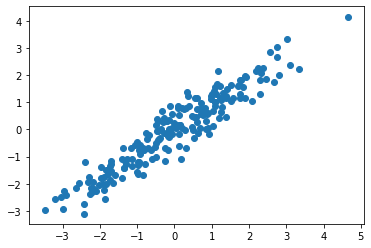

In [11]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)

### Missing data

X is just like X_hidden, except that some data goes missing...

In [12]:
n_train = X_hidden.shape[0]

## create a randomly shuffled boolean vector of missingness
missing = np.concatenate((
    np.repeat(True, n_train//2),
    np.repeat(False, n_train-n_train//2)))
np.random.shuffle(missing)

In [13]:
X = X_hidden.copy()
X[:,3] = np.where(missing, np.nan, X[:,3])

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [15]:
print('{} missing out of {}'.format(sum(np.isnan(X_train[:,3])), X_train.shape[0]))

396 missing out of 800


In [16]:
np.nanmean(X_train[:,3])

0.05661455192831444

### Mean imputation

In [17]:
imr = SimpleImputer(add_indicator=False, strategy='mean')
imr = imr.fit(X)
X_imputed = imr.transform(X)

In [18]:
X_imputed

array([[-0.121, -0.615,  0.432,  0.02 ],
       [-0.007, -0.251,  0.762,  0.02 ],
       [-0.722,  0.314,  2.344, -0.574],
       ...,
       [-0.068, -1.149,  0.986,  0.02 ],
       [-1.126,  0.722, -0.417,  1.688],
       [ 0.594,  0.077,  1.493, -0.321]])

### Train on mean-imputed data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.20)

In [20]:
model = LinearRegression().fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.7137423277674069, 0.6905024979698031)

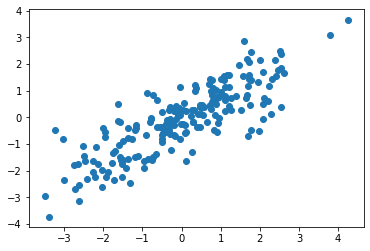

In [21]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)

### Correlated features

In [22]:
def transform(row):
    a,b,c,d = row
    return (a, b, (a+c+d)/3, d)

In [23]:
X = np.apply_along_axis(transform, arr=X_hidden, axis=1)

In [24]:
X[:,3] = np.where(missing, np.nan, X[:,3])

In [25]:
imr = SimpleImputer(add_indicator=False, strategy='mean')
imr = imr.fit(X)
X_imputed = imr.transform(X)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.20)

In [27]:
model = LinearRegression().fit(X_train, y_train)
model.score(X_train, y_train), model.score(X_test, y_test)

(0.8914485740401966, 0.8819110317918756)

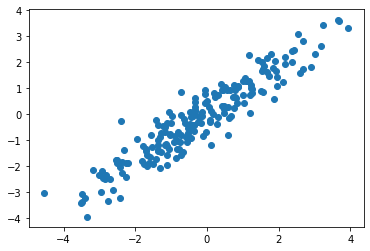

In [28]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)

## Categorical data

### Encoding ordinal variables

In [29]:
df = pd.DataFrame([['green', 'M', 10.1, 'class2'],
                   ['red', 'L', 13.5, 'class1'],
                   ['blue', 'XL', 15.3, 'class2']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [30]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [31]:
inv_size_mapping = {v: k for k, v in size_mapping.items()}
inv_size_mapping

{3: 'XL', 2: 'L', 1: 'M'}

### Encoding unordered categorical variables

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [33]:
ct = ColumnTransformer([("color-one-hot", OneHotEncoder(categories='auto'), [0])],
                       remainder='passthrough')

In [34]:
df

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [35]:
X = df[['color', 'size', 'price']].values
ct.fit_transform(X)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

### Encoding class labels (target variable)

Our target variable is `classlabel`. Scikit-learn's estimators for classification treat their output class labels, aka target variables, as unodered categorical data.

In [36]:
from sklearn.preprocessing import LabelEncoder

In [37]:
classlabel_encoder = LabelEncoder()
y = classlabel_encoder.fit_transform(df['classlabel'].values)
y

array([1, 0, 1])

In [38]:
classlabel_encoder.inverse_transform(y)

array(['class2', 'class1', 'class2'], dtype=object)